In [39]:
# Dependencies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import make_scorer, cohen_kappa_score, accuracy_score
pd.set_option('display.max_columns', None)
import joblib

pet_df = pd.read_csv("../data/train/train.csv") #Beware of directory

In [ ]:
# TODO: lookup sentiment
# TODO: text feature (TF-IDF)
from sklearn.feature_extraction.text import TfidfVectorizer
# Target encoding
def featurize_table(data_df, tfidf_vectorizer=None, is_train=True):
    tabular_df = data_df.copy()
    # Namelength
    tabular_df["name_length"] = tabular_df['Name'].str.len().fillna(0)
    
    # Description length
    tabular_df['description_length'] = tabular_df['Description'].str.len().fillna(0)
    
    
    # Is Mixed Breed? (Breed2 is not 0)
    tabular_df['is_mixed_breed'] = (tabular_df['Breed2'] != 0).astype(int)
    
    # Number of Colors (Count non-zero color columns)
    tabular_df['num_colors'] = (tabular_df[['Color1', 'Color2', 'Color3']] != 0).sum(axis=1)
    
    # Is Free? (Fee is 0)
    tabular_df['is_free'] = (tabular_df['Fee'] == 0).astype(int)

    # Fee per Pet (Normizalized for litters)
    tabular_df['fee_per_pet'] = tabular_df['Fee'] / tabular_df['Quantity'].replace(0, 1)

    # Total Media (Engagement proxy)
    tabular_df['total_media'] = tabular_df['PhotoAmt'] + tabular_df['VideoAmt']

    # Health Issue Flag (Health > 1 implies injury or condition)
    tabular_df['has_health_issue'] = (tabular_df['Health'] > 1).astype(int)
    # --------------------
    
    
    # Encode state/breed as categories
    # ADDED 'Type' to this list
    cat_cols = ['Type', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2', 'Color3', 
                    'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 
                    'Sterilized', 'Health', 'State']
    for col in cat_cols:
        if col in tabular_df.columns:
            tabular_df[col] = tabular_df[col].astype('category')
        
    # Sentiment Analysis from JSON
    #print("Extracting sentiment features...")
    #sentiment_features = tabular_df['PetID'].apply(lambda x: extract_sentiment(x, True))
    #tabular_df['sentiment_score'] = [x[0] for x in sentiment_features]
    #tabular_df['sentiment_magnitude'] = [x[1] for x in sentiment_features]
    
    # TF-IDF
    descriptions = tabular_df['Description']
    # Drop unused columns (Including RescuerID now)
    tabular_df.drop(['Name', 'PetID', 'Description'], axis=1, inplace=True)
    
    if is_train:
        tfidf = TfidfVectorizer(max_features=100, stop_words='english')
        tfidf_matrix = tfidf.fit_transform(descriptions)
        
        # Create a Dataframe for tfidf features
        tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=[f"tfidf_{i}" for i in range(100)])
        # Return features, also vectorizer to be used on inference
        return pd.concat([tabular_df.reset_index(drop=True), tfidf_df], axis=1), tfidf
    else:
        # Use existing vectorizer
        tfidf_matrix = tfidf_vectorizer.transform(descriptions)
        tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=[f"tfidf_{i}" for i in range(100)])
        return pd.concat([tabular_df.reset_index(drop=True), tfidf_df], axis=1)
    return tabular_df

pet_features = featurize_table(pet_df)
pet_features.head()

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,PhotoAmt,AdoptionSpeed,name_length,description_length,is_mixed_breed,num_colors,is_free,fee_per_pet,total_media,has_health_issue
0,2,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,1.0,2,6.0,359.0,0,2,0,100.0,1.0,0
1,2,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,2.0,0,11.0,118.0,0,2,1,0.0,2.0,0
2,1,1,307,0,1,2,7,0,2,2,1,1,2,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,7.0,3,6.0,393.0,0,2,1,0.0,7.0,0
3,1,4,307,0,2,1,2,0,2,1,1,1,2,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,8.0,2,4.0,146.0,0,2,0,150.0,8.0,0
4,1,1,307,0,1,1,0,0,2,1,2,2,2,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,3.0,2,6.0,390.0,0,1,1,0.0,3.0,0


In [11]:
# Splitting the data from train.csv
X = pet_features.drop(['AdoptionSpeed'], axis=1)
y = pet_features['AdoptionSpeed'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TODO: create a mapping for count encoding rescuerID
rescuer_counts = X_train["RescuerID"].value_counts()
X_train['rescuer_count'] = X_train['RescuerID'].map(rescuer_counts)

X_test['rescuer_count'] = X_test['RescuerID'].map(rescuer_counts).fillna(0)

X_train.drop('RescuerID', axis=1, inplace=True)
X_test.drop('RescuerID', axis=1, inplace=True)

In [12]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
prediction_dummy = dummy_clf.predict(X_test)

# Pure XGBoost

In [13]:
# XGBoost (Basic)
xgb_clf = xgb.XGBClassifier(
    objective='clf:accuracy',
    n_estimators = 100,
    learning_rate=0.1,
    max_depth=2,
    #early_stopping_rounds=50, # Use early stoppage to mitigate overfitting
    n_jobs=-1 # enables parallel on all cores for faster training
)

xgb_clf.fit(X_train, y_train)
prediction_xgb = xgb_clf.predict(X_test)


In [14]:
# XGBoost (Tuned)
"""
parameters = {
    'n_estimators': [50, 100, 200, 250],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [5, 7, 9, 12],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}

rscv = RandomizedSearchCV(
    estimator=xgb.XGBClassifier(objective="multi:softprob", # softmax only return the winning class, this will return a vector we want
                                eval_metric = "mlogloss"), # validation metric for early stoppage in training
    param_distributions=parameters,
    scoring=make_scorer(cohen_kappa_score, weights='quadratic'), # Decider for best model from rscv
    n_iter=50, # Try n random combinations
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1 # Parallel processing
)

rscv.fit(X_train, y_train)
print (f"Best Parameters: {rscv.best_params_}")
print (f"Average Quadratic Weighted Kappa Score on all validation folds: {rscv.best_score_:.4f}")
xgb_bestmodel = rscv.best_estimator_
prediction_xgb_best = xgb_bestmodel.predict(X_test) # Get class prediction
probs_xgb_best = xgb_bestmodel.predict_proba(X_test) # Get probs for all classes

prediction_train = xgb_bestmodel.predict(X_train)
print(f"Real Kappa on Training Set: {cohen_kappa_score(prediction_train, y_train, weights='quadratic'):.4f}")
"""


'\nparameters = {\n    \'n_estimators\': [50, 100, 200, 250],\n    \'learning_rate\': [0.01, 0.05, 0.1, 0.2],\n    \'max_depth\': [5, 7, 9, 12],\n    \'subsample\': [0.7, 0.8, 0.9, 1.0],\n    \'colsample_bytree\': [0.6, 0.7, 0.8, 0.9, 1.0]\n}\n\nrscv = RandomizedSearchCV(\n    estimator=xgb.XGBClassifier(objective="multi:softprob", # softmax only return the winning class, this will return a vector we want\n                                eval_metric = "mlogloss"), # validation metric for early stoppage in training\n    param_distributions=parameters,\n    scoring=make_scorer(cohen_kappa_score, weights=\'quadratic\'), # Decider for best model from rscv\n    n_iter=50, # Try n random combinations\n    cv=5,\n    verbose=1,\n    random_state=42,\n    n_jobs=-1 # Parallel processing\n)\n\nrscv.fit(X_train, y_train)\nprint (f"Best Parameters: {rscv.best_params_}")\nprint (f"Average Quadratic Weighted Kappa Score on all validation folds: {rscv.best_score_:.4f}")\nxgb_bestmodel = rscv.best_es

In [15]:
# Hyperparameter-tuning w/Optuna
import optuna
import xgboost as xgb
from sklearn.metrics import cohen_kappa_score
import torch
def objective(trial):
    params = {
        'objective': 'multi:softprob',
        'eval_metric': 'mlogloss',
        'num_class': 5,
        'tree_method': 'hist', # Faster training
        'device': 'cuda' if torch.cuda.is_available() else 'cpu', # Use GPU if available
        # Tuning parameters
        'n_estimators': trial.suggest_int('n_estimators', 200, 1000), # More trees, but early stopping handles it
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
    }

    # Split for early stopping (Optuna needs a validation set)
    # Using specific validation set (futher split from train set)
    X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, 
                                                #stratify=y_train
                                                )

    # Choose regressor if trying to use with optimied rounder
    model = xgb.XGBClassifier(**params, early_stopping_rounds=50)
    
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    
    preds = model.predict(X_val)
    kappa = cohen_kappa_score(y_val, preds, weights='quadratic')
    return kappa

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50) # Run 50 smart trials

print(f"Best trial value: {study.best_value}")
print(f"Best params: {study.best_params}")

# Use best params
best_params = study.best_params
# Add fixed params back
best_params['objective'] = 'multi:softprob'
best_params['num_class'] = 5

xgb_optuna = xgb.XGBClassifier(**best_params)
xgb_optuna.fit(X_train, y_train) 
prediction_xgb_optuna = xgb_optuna.predict(X_test)
joblib.dump(xgb_optuna, 'xgb_optuna.pkl')

[I 2026-02-15 13:20:51,718] A new study created in memory with name: no-name-07ee7ee0-80a9-4367-816d-e5e849ab6b5f
[I 2026-02-15 13:20:53,851] Trial 0 finished with value: 0.41887356708810464 and parameters: {'n_estimators': 594, 'learning_rate': 0.052416740437630116, 'max_depth': 7, 'subsample': 0.7256001151892301, 'colsample_bytree': 0.7723742394196941, 'min_child_weight': 1, 'reg_alpha': 5.993881094533176, 'reg_lambda': 9.613353892492805}. Best is trial 0 with value: 0.41887356708810464.
[I 2026-02-15 13:20:56,721] Trial 1 finished with value: 0.4175090459189509 and parameters: {'n_estimators': 436, 'learning_rate': 0.016850437230908403, 'max_depth': 9, 'subsample': 0.7408669885947923, 'colsample_bytree': 0.9329672262649585, 'min_child_weight': 5, 'reg_alpha': 2.6849083605292465, 'reg_lambda': 6.571234395415612}. Best is trial 0 with value: 0.41887356708810464.
[I 2026-02-15 13:20:58,807] Trial 2 finished with value: 0.4249229941086754 and parameters: {'n_estimators': 309, 'learning_

Best trial value: 0.44197281719641035
Best params: {'n_estimators': 860, 'learning_rate': 0.009037735056896395, 'max_depth': 12, 'subsample': 0.6171012303459075, 'colsample_bytree': 0.822466124628807, 'min_child_weight': 3, 'reg_alpha': 0.06688797397296709, 'reg_lambda': 0.18976145197431737}


['xgb_optuna.pkl']

In [26]:
# Hyperparameter-tuning w/Optuna (Regressor)
import optuna
import xgboost as xgb
from sklearn.metrics import cohen_kappa_score
import torch
def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        #'num_class': 5,
        'tree_method': 'hist', # Faster training
        'device': 'cuda' if torch.cuda.is_available() else 'cpu', # Use GPU if available
        # Tuning parameters
        'n_estimators': trial.suggest_int('n_estimators', 200, 1000), # More trees, but early stopping handles it
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
    }

    # Split for early stopping (Optuna needs a validation set)
    # Using specific validation set
    X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, 
                                                #stratify=y_train
                                                )

    # Choose regressor if trying to use with optimied rounder
    model = xgb.XGBRegressor(**params, early_stopping_rounds=50)
    
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    
    # FIXED: Round continuous predictions to integers for Kappa calculation
    preds = model.predict(X_val)
    preds_rounded = np.rint(preds).astype(int).clip(0, 4) 
    kappa = cohen_kappa_score(y_val, preds_rounded, weights='quadratic')
    return kappa

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50) # Run 50 smart trials

print(f"Best trial value: {study.best_value}")
print(f"Best params: {study.best_params}")

# Use best params
best_params = study.best_params
# Add fixed params back
best_params['objective'] = 'reg:squarederror'

xgb_optuna_reg = xgb.XGBRegressor(**best_params)
xgb_optuna_reg.fit(X_train, y_train) 
prediction_reg_raw = xgb_optuna_reg.predict(X_test)
prediction_xgb_reg = np.rint(prediction_reg_raw).astype(int).clip(0, 4)
joblib.dump(xgb_optuna_reg, 'xgb_optuna_reg.pkl')

Best trial value: 0.39861111111111114
Best params: {'n_estimators': 793, 'learning_rate': 0.0173479773032578, 'max_depth': 10, 'subsample': 0.9705738392968393, 'colsample_bytree': 0.9839003732751974, 'min_child_weight': 3, 'reg_alpha': 1.1352592533617638, 'reg_lambda': 8.635414808107326}


['xgb_optuna_reg.pkl']

In [17]:
# This works!
import numpy as np
from scipy.optimize import minimize
from sklearn.metrics import cohen_kappa_score
from functools import partial
xgb_testing = joblib.load("../models/v1_stratify/xgb_stratify_optuna.pkl")
class OptimizedRounder:
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        # Bins predictions based on the coefficients (thresholds)
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4

        ll = cohen_kappa_score(y, X_p, weights='quadratic')
        return -ll # Minimize the negative kappa (maximize kappa)

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        # Start with standard rounding thresholds
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p
# 1. Get Probability Predictions from your tuned model
probs_train = xgb_testing.predict_proba(X_train)
probs_test = xgb_testing.predict_proba(X_test)

# 2. Convert to Expected Value (continuous calculation: sum(prob * class_label))
# This turns probabilities into a single number (e.g., 2.34)
train_preds_continuous = np.sum(probs_train * np.arange(5), axis=1)
test_preds_continuous = np.sum(probs_test * np.arange(5), axis=1)

# 3. Fit the Optimized Rounder on Training Data
optR = OptimizedRounder()
optR.fit(train_preds_continuous, y_train)

# View the learned thresholds (e.g., instead of 0.5, it might be 0.6)
print(f"Optimized Thresholds: {optR.coef_['x']}")

# 4. Predict on Test Data using the new thresholds
final_predictions = optR.predict(test_preds_continuous, optR.coef_['x'])
print (final_predictions)
# 5. Evaluate
print("Optimized Kappa:", cohen_kappa_score(y_test, final_predictions, weights='quadratic'))
print (f"Original Kappa is {cohen_kappa_score(y_test, prediction_xgb_optuna, weights='quadratic')}")

Optimized Thresholds: [0.52654719 1.69745624 2.48101806 3.3206787 ]
[4. 2. 4. ... 2. 4. 3.]
Optimized Kappa: 0.8769456623006578
Original Kappa is 0.395690369237631


In [34]:
# This also works
from oprounder import OptimizedRounder
import numpy as np
from sklearn.metrics import cohen_kappa_score


# Get Probability Predictions from your tuned model
probs_train_clf = xgb_optuna.predict_proba(X_train)
probs_test_clf = xgb_optuna.predict_proba(X_test)

# Convert to Expected Value (continuous calculation: sum(prob * class_label))
# This turns probabilities into a single number (e.g., 2.34)
train_preds_continuous = np.sum(probs_train_clf * np.arange(5), axis=1)
test_preds_continuous = np.sum(probs_test_clf * np.arange(5), axis=1)

# Fit the Optimized Rounder on Training Data
rounder = OptimizedRounder(n_classes=y_train.nunique(), n_trials=100)
rounder.fit(train_preds_continuous, y_train) #TODO: Change this appro.


# View the learned thresholds
print(f'Optimal thresholds: {rounder.thresholds}')

# Predict on Test Data using the new thresholds
prediction_clf_optimized = rounder.predict(test_preds_continuous) # use the new threshold to pick label

# Compare how the new threshold improve kappa
kappa = cohen_kappa_score(y_test, prediction_clf_optimized, weights='quadratic')
print(f'Optimal Quadratic kappa: {kappa:.4f}')

kappa = cohen_kappa_score(y_test, prediction_xgb_optuna, weights='quadratic')
print(f'Original Quadratic kappa: {kappa:.4f}')


Optimal thresholds: [1.073699018565312, 1.982124080826686, 2.4752246488824428, 3.098275842155716]
Optimal Quadratic kappa: 0.4726
Original Quadratic kappa: 0.3957


In [36]:
# Regressor version 
from oprounder import OptimizedRounder
import numpy as np
from sklearn.metrics import cohen_kappa_score
pred_train_reg = xgb_optuna_reg.predict(X_train)
pred_test_reg = xgb_optuna_reg.predict(X_test)

# Fit the Optimized Rounder on Training Data
rounder = OptimizedRounder(n_classes=y_train.nunique(), n_trials=100)
rounder.fit(pred_train_reg, y_train) #TODO: Change this appro.


# View the learned thresholds
print(f'Optimal thresholds: {rounder.thresholds}')

# Predict on Test Data using the new thresholds
prediction_reg_optimized = rounder.predict(test_preds_continuous) # use the new threshold to pick label

# Compare how the new threshold improve kappa
kappa = cohen_kappa_score(y_test, prediction_reg_optimized, weights='quadratic')
print(f'Optimal Quadratic kappa: {kappa:.4f}')

kappa = cohen_kappa_score(y_test, prediction_xgb_reg, weights='quadratic')
print(f'Original Quadratic kappa: {kappa:.4f}')


Optimal thresholds: [1.1327455285952075, 1.858993744899881, 2.6334310043069786, 3.0607235624869666]
Optimal Quadratic kappa: 0.4422
Original Quadratic kappa: 0.3707


# Evaluate

In [ ]:
from sklearn.metrics import cohen_kappa_score, accuracy_score

def evaluate_model(model, model_prediction):
    print(f"Model: {model.__class__.__name__}")
    print(f"Kappa Score: {cohen_kappa_score(model_prediction, y_test, weights='quadratic'):.4f}")
    print(f"Accuracy Score: {accuracy_score(model_prediction, y_test):.4f}")
    

evaluate_model(dummy_clf, prediction_dummy) # Kappa should be 0 bcuz it's random
print(f"Unique predictions by Dummy Classifier: {np.unique(prediction_dummy)}")
print ("")

print ("- Basic XGBoost Classifier")
evaluate_model(xgb_clf, prediction_xgb)
print ("")
#print ("- Tuned XGBoost Classifier- ")
#evaluate_model(xgb_bestmodel, prediction_xgb_best)

print ("- Tuned XGBoost Classifier (w/Optuna) - ")
evaluate_model(xgb_optuna, prediction_xgb_optuna)
print ("")

print ("- Tuned XGBoost Regressor (Standard Rounding) - ")
evaluate_model(xgb_optuna_reg, prediction_xgb_reg)
print ("")

print ("- Tuned XGBoost Regressor (Optimized Rounding) - ")
evaluate_model(xgb_optuna_reg, prediction_xgb_reg)
print ("")

Model: DummyClassifier
Kappa Score: 0.0000
Accuracy Score: 0.2778
Unique predictions by Dummy Classifier: [4]

- Basic XGBoost Classifier
Model: XGBClassifier
Kappa Score: 0.3399
Accuracy Score: 0.4258

- Tuned XGBoost Classifier (w/Optuna) - 
Model: XGBClassifier
Kappa Score: 0.3957
Accuracy Score: 0.4542

- Tuned XGBoost Regressor - 
Model: XGBRegressor
Kappa Score: 0.3707
Accuracy Score: 0.3278



<Figure size 1200x600 with 0 Axes>

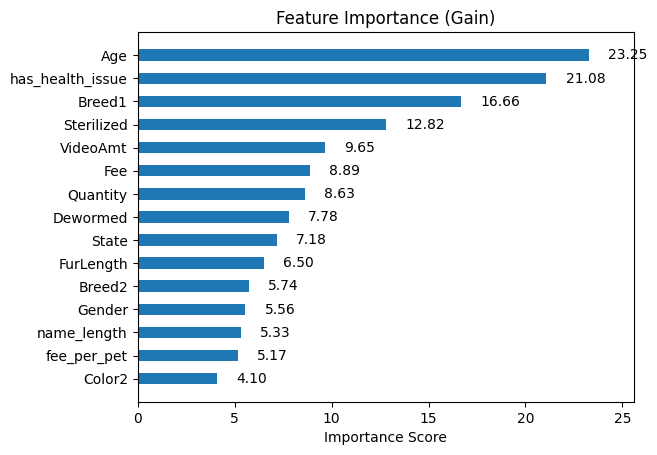

In [43]:
# Feature Importance: which factors benefit the prediction the most (extracted from XGBoost)
# ensure usage of original feature names not just np array indices
xgb_clf.get_booster().feature_names = list(X.columns)

plt.figure(figsize=(12,6))
xgb.plot_importance(xgb_clf, max_num_features=15, height=0.5, importance_type="gain", values_format = "{v:.2f}") # Weight ใช้อะไรมากที่สุดเป็นส่วนประกอบ tree, Gain อะไรแบ่งได้มากสุด
plt.title("Feature Importance (Gain)")
plt.xlabel("Importance Score")
plt.ylabel("")
plt.grid(False)
plt.show()

<Figure size 1200x600 with 0 Axes>

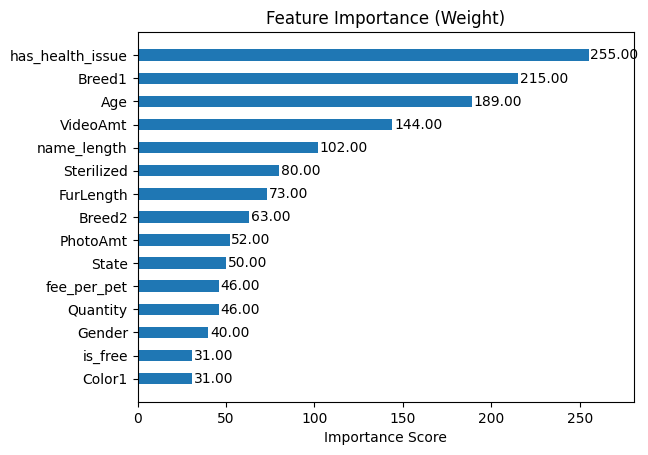

In [44]:
# Feature Importance: which factors benefit the prediction the most (extracted from XGBoost)
# ensure usage of original feature names not just np array indices
xgb_clf.get_booster().feature_names = list(X.columns)

plt.figure(figsize=(12,6))
xgb.plot_importance(xgb_clf, max_num_features=15, height=0.5, importance_type="weight", values_format = "{v:.2f}") # Weight ใช้อะไรมากที่สุดเป็นส่วนประกอบ tree, Gain อะไรแบ่งได้มากสุด
plt.title("Feature Importance (Weight)")
plt.xlabel("Importance Score")
plt.ylabel("")
plt.grid(False)
plt.show()